# Modeling Data / Feature Selection
- Create Upsampled and Downsampled datasets
- Merge datasets 
- Observe HDD and CDD load shapes 
- Add lags + rolling_mean

Setup

In [1]:
import pandas as pd
from pathlib import Path
import pickle
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import numpy as np

# Multiple outputs per notebook cell
%config InteractiveShell.ast_node_interactivity = 'all'

In [2]:
def dd_hourly_pivot(df): # requires country actuals
    '''
    Description: pivots table long-ways, with country and aggregated hourly 
    actuals load as columns
    '''
    return (df.pivot_table(index=['day', 'country', 'hdd', 'cdd'], 
                           values='load_actual', 
                           columns = 'hour', 
                           aggfunc='sum')
                            # remove first day with NaNs
              .dropna()
              .reset_index(level=1))

def dd_plot_norm_avg_hourly(df, group, pivot=True): # requires df from hourly_pivot function
    '''
    Description: min-max normalization of input data across each hour
    '''
    df = df.groupby(by=group, as_index=True).mean(numeric_only=True).round(2) # .reset_index()
    # hour columns
    cols = list(range(24))

    # columns for row-wise min-max normalization
    df['min'] = df[cols].min(axis=1)
    df['max'] = df[cols].max(axis=1)

    # Row-wise Min-max normalization 
    df[cols] = (df[cols].sub(df['min'], axis=0)
                        .div(df['max'] - df['min'], axis=0))
    
    # Melt for overlapping lineplots
    if pivot:
        df = (df.reset_index()
                .melt(id_vars=group,
                      value_vars=cols)
                .assign(hour = lambda x: pd.to_numeric(x.hour))
                )
        
    return df

def multi_lineplots(plot_df, group): # requires df from norm_avg_hourly function  
    '''
    Description: Creates overlapping line plots for each country given a dataframe
    from the 'norm_avg_hourly' function.
    '''
    colors = sns.color_palette('magma')
    _ = plt.figure(figsize=(6, 4))

    # Create dataset and plot for each time series in group
    for grouping, color in zip(plot_df[group].unique(), colors):
        line_plot = (plot_df[plot_df[group] == grouping])
        _ = sns.lineplot(
            data=line_plot,
            x='hour',
            y='value',
            color=color,
            label = str(grouping)
        )

        _ = plt.xlabel('Hour')
        _ = plt.ylabel('Normalized Load Actual')
        _ = plt.title(f'Avg Load Shapes by {group} 2015-2019')
    
    plt.show()

def lags_and_rolling_means(df, 
                           list_vars=None, 
                           group='country', 
                           lag_num=1,
                           obs_per_day=1):
    '''
    Description: With data frame, list of variables, and hours to lag/roll, 
    adds lags and rolling mean to a copy of the dataframe. 
    *Requires a group argument
    '''
    df_copy = df.copy(deep=True)

    # iterate over variables
    for var in list_vars:
        # iterate over hours
        for lag in lag_num:
            # lag columns
            lag_col = f"{var}_lag{int(lag/obs_per_day)}_days" 
            df_copy[lag_col] = df_copy.groupby(group, as_index=False)[var].shift(lag)
            # rolling columns
            roll_col = f"{var}_rollmean{int(lag/obs_per_day)}_days" 
            df_copy[roll_col] = df_copy.groupby(group, as_index=False)[var].rolling(lag).mean()[[var]]
    
    return df_copy

Read in Data

In [15]:
# Filepaths
cd = Path.cwd()
data_dir = str(cd.parents[1])
load_wthr_dt = data_dir + '/datasets/country_energy/pivot_country_weather.pickle'
load_energy_dt = data_dir + '/datasets/country_energy/country_load.pickle'

# Read pickle data
with open(load_wthr_dt, 'rb') as f:
    wthr_dt = (pickle.load(f).loc[lambda x: x.utc_timestamp.between('2015-01-01', '2019-04-30')]
                             # Note: setting utc_timestamp as index causes drop_duplicates to remove needed observations
                             .set_index(['utc_timestamp']) 
                             # simplify var names
                             .rename(columns={'radiation_direct_horizontal': 'radi_direct',
                                              'radiation_diffuse_horizontal': 'radi_diffuse'}))

with open(load_energy_dt, 'rb') as f:
    load_dt = (pickle.load(f).loc[lambda x: x.utc_timestamp.between('2015-01-01', '2019-04-30')]
                             .set_index(['utc_timestamp']) 
                             # simplify var names
                             .rename(columns={'load_actual_entsoe_transparency': 'load_actual'}))

# View data
print(f'Weather data')
wthr_dt.head(2)
wthr_dt.tail(2)
print(f'\nLoad data')
load_dt.head(2)
load_dt.tail(2)
print(f'\nnrow weather data: {len(wthr_dt)} nrow load data: {len(load_dt)}')

Weather data


,country,temperature,radi_direct,radi_diffuse,day,mean_temp,max_temp,min_temp,hdd,cdd
utc_timestamp,,,,,,,,,,
2015-01-01 00:00:00+00:00,LU,-1.983,0.0,0.0,2015-01-01,-1.119535,3.298,-8.399,1,0
2015-01-01 01:00:00+00:00,LU,-2.083,0.0,0.0,2015-01-01,-1.119535,3.298,-8.399,1,0


,country,temperature,radi_direct,radi_diffuse,day,mean_temp,max_temp,min_temp,hdd,cdd
utc_timestamp,,,,,,,,,,
2019-04-29 23:00:00+00:00,AT,3.977,0.0,0.0,2019-04-29,9.270035,16.482,2.108,1,0
2019-04-30 00:00:00+00:00,AT,3.768,0.0,0.0,2019-04-30,10.341215,16.567,3.435,1,0



Load data


,country,load_actual,day,day_ordinal,hour,week_of_year,month,year,is_weekend,is_holiday
utc_timestamp,,,,,,,,,,
2015-01-01 00:00:00+00:00,DE,41230.04,2015-01-01,735599,0,1,1,2015,0,1
2015-01-01 00:15:00+00:00,DE,40809.76,2015-01-01,735599,0,1,1,2015,0,1


,country,load_actual,day,day_ordinal,hour,week_of_year,month,year,is_weekend,is_holiday
utc_timestamp,,,,,,,,,,
2019-04-29 23:45:00+00:00,LU,336.93,2019-04-29,737178,23,18,4,2019,0,0
2019-04-30 00:00:00+00:00,LU,337.64,2019-04-30,737179,0,18,4,2019,0,0



nrow weather data: 227526 nrow load data: 910086


Downsample Actuals from 15 min -> 1 hour

In [16]:
load_downsample = pd.DataFrame({})

# Downsample by country, merge numeric and non-numeric
for country in load_dt['country'].unique():
    
    # Country level data
    country_dt = load_dt.loc[load_dt['country'] == country]

    # Seperate numeric and non-numeric data
    non_numeric = country_dt.select_dtypes(exclude=['number']).columns
    time_country = country_dt[non_numeric].resample('h').first()

    # Combined
    country_dt = (load_dt.loc[load_dt['country'] == country]
                         .resample('h', level=0, group_keys=True)
                         .mean(numeric_only=True)
                         .merge(time_country, how='left', on=['utc_timestamp'])
                         [['day', 'day_ordinal', 'year', 'week_of_year', 'month', 'hour', 
                           'country', 'load_actual', 'is_weekend', 'is_holiday']])
    
    load_downsample = pd.concat([load_downsample, country_dt])

# View data
load_downsample.head()

# Ensure Weather and Load data have same number of rows
print(f'\n Weather data nrows: {len(wthr_dt)} Load data nrows: {len(load_downsample)}')

,day,day_ordinal,year,week_of_year,month,hour,country,load_actual,is_weekend,is_holiday
utc_timestamp,,,,,,,,,,
2015-01-01 00:00:00+00:00,2015-01-01,735599.0,2015.0,1.0,1.0,0.0,DE,40665.1075,0.0,1.0
2015-01-01 01:00:00+00:00,2015-01-01,735599.0,2015.0,1.0,1.0,1.0,DE,39509.8525,0.0,1.0
2015-01-01 02:00:00+00:00,2015-01-01,735599.0,2015.0,1.0,1.0,2.0,DE,38537.0625,0.0,1.0
2015-01-01 03:00:00+00:00,2015-01-01,735599.0,2015.0,1.0,1.0,3.0,DE,38152.6500,0.0,1.0
2015-01-01 04:00:00+00:00,2015-01-01,735599.0,2015.0,1.0,1.0,4.0,DE,37927.0550,0.0,1.0



 Weather data nrows: 227526 Load data nrows: 227526


Upsample Temperature 1 hour -> 15 min, Interpolate

In [18]:
# Upsample weather

ffill_vars = ['country', 'day', 'mean_temp', 'max_temp', 'min_temp', 'hdd', 'cdd']
interp_vars = ['temperature', 'radi_direct', 'radi_diffuse']
wthr_upsample = pd.DataFrame({})

for country in wthr_dt['country'].unique():
    country_upsample = wthr_dt.loc[lambda x: x.country == country].resample('15min').asfreq()
    # interpolate ts variables, and ffill categorical variables
    interped = country_upsample[interp_vars].interpolate()
    ffilled = country_upsample[ffill_vars].ffill()

    # merge
    upsampled = interped.merge(ffilled, how='left', on='utc_timestamp')

    wthr_upsample = pd.concat([wthr_upsample, upsampled])

wthr_upsample.head(2)

# Ensure accuracy
print(f"Ensure correct counts for upsampled dataframes:\nwthr_dt - {len(wthr_dt)}, country_upsample - {len(country_upsample)} (1/6th of wthr_upsample), wthr_upsample - {len(wthr_upsample)}\n\nEnsure 4 * len(wthr_dt) == len(wthr_upsample): wthr_dt - {4 * len(wthr_dt)}, wthr_upsample - {len(wthr_upsample)}")

print(f'\nDifference from 4 * wrthr_dt to wthr_upsample: {910104 - 910086}')

,temperature,radi_direct,radi_diffuse,country,day,mean_temp,max_temp,min_temp,hdd,cdd
utc_timestamp,,,,,,,,,,
2015-01-01 00:00:00+00:00,-1.983,0.0,0.0,LU,2015-01-01,-1.119535,3.298,-8.399,1.0,0.0
2015-01-01 00:15:00+00:00,-2.008,0.0,0.0,LU,2015-01-01,-1.119535,3.298,-8.399,1.0,0.0


Ensure correct counts for upsampled dataframes:
wthr_dt - 227526, country_upsample - 151681 (1/6th of wthr_upsample), wthr_upsample - 910086

Ensure 4 * len(wthr_dt) == len(wthr_upsample): wthr_dt - 910104, wthr_upsample - 910086

Difference from 4 * wrthr_dt to wthr_upsample: 18


Investigating difference in size of dataframes after resampling

In [12]:
# Reset utc_timestamp as variable for comparison
test_timestamp_a = wthr_dt.reset_index()
test_timestamp_b = wthr_upsample.reset_index()

print(f"How many timestamps are not shared between tables?")
test_timestamp_a.loc[lambda x: ~x['utc_timestamp'].isin(test_timestamp_b['utc_timestamp'])] # empty
print('--- All timestamps are shared')

How many timestamps are not shared between tables?


,utc_timestamp,country,temperature,radi_direct,radi_diffuse,day,mean_temp,max_temp,min_temp,hdd,cdd


--- All timestamps are shared


For the 6 countries 3 extra observations exist (6*3) = 18. This corresponds, correctly, to the 3 additional rows per country not being created for the final time value in the wthr_dt table. Fortunately, the difference is not cause for concern!

Merge datasets

In [19]:
# Downsampled dataset
load_wthr_down = load_downsample.merge(wthr_dt, how='left', on=['utc_timestamp', 'country', 'day'])
print(f"Downsampled Dataset")
load_wthr_down.head(2)

# Upsampled dataset
load_dt = load_dt[['day', 'day_ordinal', 'year', 'week_of_year', 'month', 'hour', # arrange variables
                   'country', 'load_actual', 'is_weekend', 'is_holiday']]
load_wthr_up = load_dt.merge(wthr_upsample, how='left', on=['utc_timestamp', 'country', 'day'])
print(f"Upsampled Dataset")
load_wthr_up.head(2)


Downsampled Dataset


,day,day_ordinal,year,week_of_year,month,hour,country,load_actual,is_weekend,is_holiday,temperature,radi_direct,radi_diffuse,mean_temp,max_temp,min_temp,hdd,cdd
utc_timestamp,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,2015-01-01,735599.0,2015.0,1.0,1.0,0.0,DE,40665.1075,0.0,1.0,-0.981,0.0,0.0,-1.119535,3.298,-8.399,1,0
2015-01-01 01:00:00+00:00,2015-01-01,735599.0,2015.0,1.0,1.0,1.0,DE,39509.8525,0.0,1.0,-1.035,0.0,0.0,-1.119535,3.298,-8.399,1,0


Upsampled Dataset


,day,day_ordinal,year,week_of_year,month,hour,country,load_actual,is_weekend,is_holiday,temperature,radi_direct,radi_diffuse,mean_temp,max_temp,min_temp,hdd,cdd
utc_timestamp,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,2015-01-01,735599,2015,1,1,0,DE,41230.04,0,1,-0.9810,0.0,0.0,-1.119535,3.298,-8.399,1.0,0.0
2015-01-01 00:15:00+00:00,2015-01-01,735599,2015,1,1,0,DE,40809.76,0,1,-0.9945,0.0,0.0,-1.119535,3.298,-8.399,1.0,0.0


HDD and CDD Load Shape clusters

In [20]:
# Prep dataframe 
day_pivot_hourly = dd_hourly_pivot(load_wthr_down)

# Transform and normalize data for time series plots
avg_hourly = (dd_plot_norm_avg_hourly(day_pivot_hourly, ['country', 'hdd', 'cdd'])
              .reset_index()
              .assign(hour = lambda x: x['hour'].astype(int)))
print(f'\nPivoted, normalized, hourly means per country')
avg_hourly.head(4)
# # plot overlapping load shapes
avg_hourly_HDD = avg_hourly.loc[avg_hourly['hdd'] == 1]
avg_hourly_CDD = avg_hourly.loc[avg_hourly['cdd'] == 1]
print(f'Ensure HDD and CDD dataframes are half the avg_hourly length {len(avg_hourly)}:\nHDD only: {len(avg_hourly_HDD)}, CDD only: {len(avg_hourly_CDD)}')

avg_hourly_HDD.head(2)
avg_hourly_CDD.head(2)


Pivoted, normalized, hourly means per country


,index,country,hdd,cdd,hour,value
0,0,AT,0,1,0,0.060322
1,1,AT,1,0,0,0.074255
2,2,BE,0,1,0,0.038100
3,3,BE,1,0,0,0.159451


Ensure HDD and CDD dataframes are half the avg_hourly length 288:
HDD only: 144, CDD only: 144


,index,country,hdd,cdd,hour,value
1,1,AT,1,0,0,0.074255
3,3,BE,1,0,0,0.159451


,index,country,hdd,cdd,hour,value
0,0,AT,0,1,0,0.060322
2,2,BE,0,1,0,0.038100


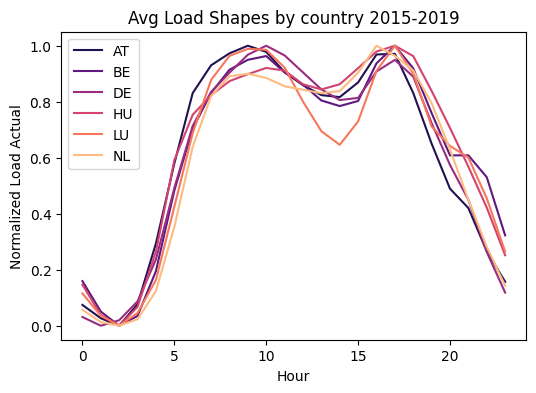

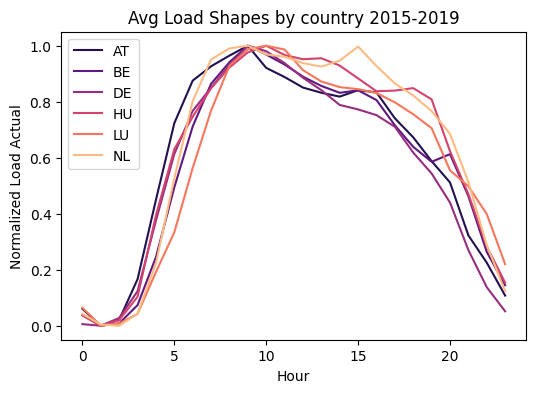

In [21]:
# HDD
multi_lineplots(avg_hourly_HDD, group='country')
# CDD
multi_lineplots(avg_hourly_CDD, group='country')

Observations for the above plots:
- Unlike residential data, a large amount of energy usage in mornings on HDD and CDD days, likely due to commercial usage. 
- CDD show much less usage in the afternoon

Create Lags and Rolling Means

In [22]:
# Add lags and rolling means
to_transform = ['temperature'] 
interval = [24,48,7*24,14*24] # 1,2,7, and 14 days
obs_per_day = 24

# Downsampled
Xd = lags_and_rolling_means(load_wthr_down, 
                            list_vars=to_transform, 
                            group='country',
                            lag_num=interval,
                            obs_per_day=obs_per_day)
Xd.iloc[:,17:].tail()

# Upsampled ( * 4 per hour)
interval = [24*4,48*4,7*24*4,14*24*4] # 1,2,7, and 14 days
obs_per_day = 24*4
Xu = lags_and_rolling_means(load_wthr_up, 
                            list_vars=to_transform, 
                            group='country',
                            lag_num=interval,
                            obs_per_day=obs_per_day)
Xu.iloc[:,17:].tail()

,cdd,temperature_lag1_days,temperature_rollmean1_days,temperature_lag2_days,temperature_rollmean2_days,temperature_lag7_days,temperature_rollmean7_days,temperature_lag14_days,temperature_rollmean14_days
utc_timestamp,,,,,,,,,
2019-04-29 20:00:00+00:00,0,5.048,10.337958,5.403,9.812917,13.404,12.097280,7.681,12.732976
2019-04-29 21:00:00+00:00,0,4.613,10.406500,5.158,9.833292,12.533,12.075149,7.124,12.736057
2019-04-29 22:00:00+00:00,0,4.333,10.486708,4.813,9.856000,11.693,12.057196,6.607,12.740482
2019-04-29 23:00:00+00:00,0,3.808,10.574958,4.423,9.883479,10.816,12.043137,6.003,12.746122
2019-04-30 00:00:00+00:00,0,3.093,10.673958,4.171,9.916208,10.039,12.033417,5.246,12.753307


,cdd,temperature_lag1_days,temperature_rollmean1_days,temperature_lag2_days,temperature_rollmean2_days,temperature_lag7_days,temperature_rollmean7_days,temperature_lag14_days,temperature_rollmean14_days
utc_timestamp,,,,,,,,,
2019-04-29 23:00:00+00:00,0.0,3.80800,10.541865,4.423,9.873174,10.81600,12.048409,6.00300,12.744007
2019-04-29 23:15:00+00:00,0.0,3.62925,10.564599,4.360,9.880372,10.62175,12.045166,5.81375,12.745514
2019-04-29 23:30:00+00:00,0.0,3.45050,10.588005,4.297,9.887898,10.42750,12.042193,5.62450,12.747117
2019-04-29 23:45:00+00:00,0.0,3.27175,10.612083,4.234,9.895753,10.23325,12.039492,5.43525,12.748816
2019-04-30 00:00:00+00:00,0.0,3.09300,10.636833,4.171,9.903935,10.03900,12.037062,5.24600,12.750612


Save Model Ready Dataframes

In [23]:
# Filepaths
cd = Path.cwd()
data_dir = str(cd.parents[1])
upsampled = data_dir + '/datasets/country_energy/load_wthr_downsample.pickle'
downsampled = data_dir + '/datasets/country_energy/load_wthr_upsample.pickle'

# Xu - upsampled
with open(upsampled, 'wb') as f:
    pickle.dump(Xu, f)

# Xd - downsampled
with open(downsampled, 'wb') as f:
    pickle.dump(Xd, f)